# Instalação e importação das bibliotecas

Instalação das bibliotecas.

In [ ]:
! pip install yfinance==0.1.74
! pip install mlrose
! pip install scikit-learn==0.22
! pip install pmdarima
! pip install pystan~=2.4
! pip install fbprophet
! pip install vectorbt
! pip install python-binance
! pip install tradingview_ta
! pip install talib-binary

Importação das bibliotecas.

In [99]:
import mlrose
import datetime
import time
import sys
# import six
# sys.modules['sklearn.externals.six'] = six

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import vectorbt as vbt
import talib as ta
import seaborn as sns

from statsmodels.tsa.seasonal import seasonal_decompose
from pmdarima.arima import auto_arima
from fbprophet import Prophet
from fbprophet.plot import plot_plotly, plot_components_plotly
from tradingview_ta import *
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import tree
from functools import reduce

# Otimização de Portifólio

Download da base de dados.

In [7]:
acoes = ["GOLL4.SA", "CVCB3.SA", "WEGE3.SA", "MGLU3.SA", "TOTS3.SA", "BOVA11.SA"]
acoes_df = pd.DataFrame()

for acao in acoes:
    acoes_df[acao] = yf.download(acao, start="2015-01-01")["Close"]

acoes_df = acoes_df.rename(
    columns={
        "GOLL4.SA": "GOL",
        "CVCB3.SA": "CVC",
        "WEGE3.SA": "WEGE",
        "MGLU3.SA": "MGLU",
        "TOTS3.SA": "TOTS",
        "BOVA11.SA": "BOVA",
    }
)

acoes_df.dropna(inplace=True)
acoes_df.to_csv("acoes.csv")

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


#### Alocação aleatória de ativos.

In [8]:
def alocacao_ativos(dataset, dinheiro_total, seed=0, melhores_pesos=[]):    
    dataset = dataset.copy()

    if seed != 0:
        np.random.seed(seed)

    if len(melhores_pesos) > 0:
        pesos = melhores_pesos
    else:
        pesos = np.random.random(len(dataset.columns) - 1)
        pesos = pesos / pesos.sum()

    colunas = dataset.columns[1:]
    for i in colunas:
        dataset[i] = dataset[i] / dataset[i][0]

    for i, acao in enumerate(dataset.columns[1:]):
        dataset[acao] = dataset[acao] * pesos[i] * dinheiro_total

    dataset["soma valor"] = dataset.sum(axis=1, numeric_only=True)

    datas = dataset["Date"]

    dataset.drop(labels=["Date"], axis=1, inplace=True)
    dataset["taxa retorno"] = 0.0

    for i in range(1, len(dataset)):
        dataset["taxa retorno"][i] = (
            (dataset["soma valor"][i] / dataset["soma valor"][i - 1]) - 1
        ) * 100

    acoes_pesos = pd.DataFrame(data={"Ações": colunas, "Pesos": pesos * 100})

    return dataset, datas, acoes_pesos, dataset.loc[len(dataset) - 1]["soma valor"]

In [9]:
dinheiro_total = 5000
dataset, datas, acoes_pesos, soma_valor = alocacao_ativos(pd.read_csv('acoes.csv'), 5000, 10)

#### Sharp Ratio

In [10]:
soma_valor - dinheiro_total

34743.60989661665

In [11]:
# Taxa selic: https://www.infomoney.com.br/guias/taxa-selic/
taxa_selic_2015 = 12.75
taxa_selic_2016 = 14.25
taxa_selic_2017 = 12.25
taxa_selic_2018 = 6.50
taxa_selic_2019 = 5.0
taxa_selic_2020 = 2.0
taxa_selic_2021 = 9.25
taxa_selic_2022 = 12.25

Rendimento durante o ano de 2015:

In [12]:
valor_2015 = dinheiro_total + (dinheiro_total * taxa_selic_2015 / 100)
valor_2015

5637.5

Rendimento durante o ano de 2016:

In [13]:
valor_2016 = valor_2015 + (valor_2015 * taxa_selic_2016 / 100)
valor_2016

6440.84375

Rendimento durante o ano de 2017:

In [14]:
valor_2017 = valor_2016 + (valor_2016 * taxa_selic_2017 / 100)
valor_2017

7229.8471093749995

Rendimento anual do ano de 2018 ao ano 2022:

In [15]:
valor_2018 = valor_2017 + (valor_2017 * taxa_selic_2018 / 100)
valor_2019 = valor_2018 + (valor_2018 * taxa_selic_2019 / 100)
valor_2020 = valor_2019 + (valor_2019 * taxa_selic_2020 / 100)
valor_2021 = valor_2020 + (valor_2020 * taxa_selic_2021 / 100)
valor_2022 = valor_2021 + (valor_2021 * taxa_selic_2022 / 100)

Rendimentos:

In [16]:
rendimentos = valor_2022 - dinheiro_total
rendimentos

5112.906390238964

Imposto de Renda:

In [17]:
ir = rendimentos * 15 / 100
ir

766.9359585358447

In [18]:
valor_2022 - ir

9345.97043170312

#### Cálculo do índice de Sharp `Anual`

> `> 0.5` é bom.
>
> `< 0.5` não é bom.

In [19]:
taxa_selic_historico = np.array([12.75, 14.25, 12.25, 6.5, 5.0, 2.0,9.25, 12.25])

In [20]:
(dataset['taxa retorno'].mean() - taxa_selic_historico.mean() / 100) / dataset['taxa retorno'].std() * np.sqrt(246)

0.31097559623423604

#### Otimização

In [21]:
dataset_original = pd.read_csv('acoes.csv')

dinheiro_total = 5000

sem_risco = taxa_selic_historico.mean() / 100

sem_risco

0.0928125

In [22]:
def fitness_function(solucao):

    # Copia do dataset original.
    dataset = dataset_original.copy()

    # Normalizacao dos pesos (valoes entre 0.0 e 1.0)
    pesos = solucao / solucao.sum()
    
    # Colunas dos ativos.
    acoes = dataset.columns[1:]

    # Valor de retorno: Valor atual dividido pelo preco inicial do ativo.
    for acao in acoes:
        preco_inicial = dataset[acao][0]
        dataset[acao] = dataset[acao] / preco_inicial

    # Analise de evolucao do lucro.
    for index, acao in enumerate(acoes):
        dataset[acao] = dataset[acao] * pesos[index] * dinheiro_total

    # Remove as datas do dataset. 
    # axis=1 remove a coluna com a label Date.
    # inplace=True faz a alteracao diretamente no dataset, sem retornar uma copia do dataset 
    # com as modificacoes.
    dataset.drop(labels=['Date'], axis=1, inplace=True)

    # Soma todos os valores de cada ativo. 
    # numeric_only=True evita somar valores numericos com strings.
    # axis=1 quer dizer que a soma sera feita por colunas.
    dataset['soma valor'] = dataset.sum(numeric_only=True, axis=1)

    # Cria uma coluna para a taxa de retorno com valores iguais a 0.0.
    dataset['taxa retorno'] = 0.0

    # Calculo da taxa de retorno diaria (%).
    for i in range(1, len(dataset)):
        dataset['taxa retorno'][i] = ((dataset['soma valor'][i] / dataset['soma valor'][i - 1]) - 1) * 100
    
    # Calculo do Sharp Ratio. 
    sharp_ratio = (dataset['taxa retorno'].mean() - sem_risco) / dataset['taxa retorno'].std() * np.sqrt(246)

    return sharp_ratio

In [23]:
def visualiza_alocacao(solucao):
    colunas = dataset_original.columns[1:]

    for i in range(len(solucao)):
        print(colunas[i], solucao[i] * 100)

Gerando pesos:

In [24]:
np.random.seed(10)
pesos = np.random.random(len(dataset_original.columns) - 1)
pesos = pesos / pesos.sum()

In [25]:
fitness_function(pesos)

0.31097559623423604

In [26]:
visualiza_alocacao(pesos)

GOL 26.617195545614496
CVC 0.7161207195395352
WEGE 21.866313475981215
MGLU 25.84017365648649
TOTS 17.202779081759033
BOVA 7.757417520619242


In [27]:
fitness = mlrose.CustomFitness(fitness_function)

In [28]:
problema_maximizacao = mlrose.ContinuousOpt(
    length=6,
    fitness_fn=fitness,
    maximize=True,
    min_val=0,
    max_val=1,
)

In [29]:
problema_minimizacao = mlrose.ContinuousOpt(
    length=6,
    fitness_fn=fitness,
    maximize=False,
    min_val=0,
    max_val=1,
)

##### Hill Climbling

- **Melhor** solução.

In [30]:
melhor_solucao, melhor_custo = mlrose.hill_climb(
    problema_maximizacao,
    random_state=10,
)

In [31]:
melhor_solucao = melhor_solucao / melhor_solucao.sum()
visualiza_alocacao(melhor_solucao)

GOL 0.0
CVC 0.0
WEGE 0.0
MGLU 100.0
TOTS 0.0
BOVA 0.0


- **Pior** solução.

In [32]:
pior_solucao, pior_custo = mlrose.hill_climb(
    problema_minimizacao,
    random_state=10,
) 

In [33]:
pior_solucao = pior_solucao / pior_solucao.sum()
visualiza_alocacao(pior_solucao)

GOL 4.4797356349876996
CVC 32.70905810270959
WEGE 0.0
MGLU 0.0
TOTS 0.0
BOVA 62.81120626230271


##### Alocação de ativos com os melhores/piores pesos (soluções):

- **Melhor** solução.

In [34]:
_, _, _, soma_valor = alocacao_ativos(
    pd.read_csv("acoes.csv"), dinheiro_total, melhores_pesos=melhor_solucao
)
soma_valor

114040.51101947427

- **Pior** solução.

In [35]:
_, _, _, soma_valor = alocacao_ativos(
    pd.read_csv("acoes.csv"), dinheiro_total, melhores_pesos=pior_solucao
)
soma_valor

8401.117047695181

# Séries temporais em bases financeiras - `ARIMA`

Download da base de dados.

In [36]:
acoes = ["GOLL4.SA", "CVCB3.SA", "WEGE3.SA", "MGLU3.SA", "TOTS3.SA", "BOVA11.SA"]
acoes_df = pd.DataFrame()

for acao in acoes:
    acoes_df[acao] = yf.download(acao, start="2015-01-01")["Close"]

acoes_df = acoes_df.rename(
    columns={
        "GOLL4.SA": "GOL",
        "CVCB3.SA": "CVC",
        "WEGE3.SA": "WEGE",
        "MGLU3.SA": "MGLU",
        "TOTS3.SA": "TOTS",
        "BOVA11.SA": "BOVA",
    }
)

acoes_df.dropna(inplace=True)
acoes_df.to_csv("acoes_1.csv")

dateparse = lambda dates: datetime.datetime.strptime(dates, "%Y-%m-%d")
dataset = pd.read_csv(
    "acoes_1.csv",
    parse_dates=["Date"],
    index_col="Date",
    date_parser=dateparse,
    usecols=["Date", "BOVA"],
)

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Adicionando as séries temporais da **BOVA** em uma variável.

In [37]:
time_series = dataset['BOVA']

Dados do dia 02/01/2015 até o dia 09/01/2015.

In [38]:
time_series['2015-01-01' : '2015-01-10']

Date
2015-01-02    47.259998
2015-01-05    46.320000
2015-01-06    46.580002
2015-01-07    48.150002
2015-01-08    48.509998
2015-01-09    47.529999
Name: BOVA, dtype: float64

Dados do dia inicial até o dia 09/01/2015.

In [39]:
time_series[: '2015-01-10']

Date
2015-01-02    47.259998
2015-01-05    46.320000
2015-01-06    46.580002
2015-01-07    48.150002
2015-01-08    48.509998
2015-01-09    47.529999
Name: BOVA, dtype: float64

Dados do ano de 2015.

In [40]:
time_series['2015']

Date
2015-01-02    47.259998
2015-01-05    46.320000
2015-01-06    46.580002
2015-01-07    48.150002
2015-01-08    48.509998
                ...    
2015-12-22    42.230000
2015-12-23    42.750000
2015-12-28    42.500000
2015-12-29    42.419998
2015-12-30    42.130001
Name: BOVA, Length: 246, dtype: float64

Visualização da série temporal da BOVA (Data, Preço).

<AxesSubplot:title={'center':'BOVA'}, xlabel='Data', ylabel='Preço'>

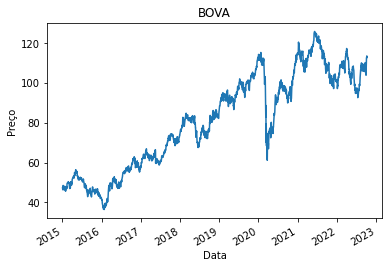

In [41]:
time_series.plot(title="BOVA", ylabel="Preço", xlabel="Data")

#### Usando o modelo ARIMA:

In [42]:
modelo = auto_arima(time_series, suppress_warnings=True, error_action='ignore')

In [43]:
modelo.order

(4, 1, 4)

Previsões para os próximos 90 dias.

In [44]:
previsoes = modelo.predict(n_periods=90)
previsoes

d:\anaconda3\envs\TECII\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


1932    113.073475
1933    113.041113
1934    113.428235
1935    113.510222
1936    113.820368
           ...    
2017    114.168193
2018    114.168194
2019    114.168183
2020    114.168162
2021    114.168136
Length: 90, dtype: float64

#### Gráfico de previsões.

Tamanho do conjunto de dados.

In [45]:
len(time_series)

1932

Conjunto de `treinamento`.

In [46]:
treinamento = time_series[:1081]

treinamento.index.min(), treinamento.index.max()

(Timestamp('2015-01-02 00:00:00'), Timestamp('2019-05-08 00:00:00'))

Conjunto de `teste`.

In [47]:
teste = time_series[1081:]

teste.index.min(), teste.index.max()

(Timestamp('2019-05-09 00:00:00'), Timestamp('2022-10-07 00:00:00'))

Criando o modelo ARIMA.

In [48]:
modelo_2 = auto_arima(treinamento, suppress_warnings=True, error_action='ignore')

In [49]:
len(teste) # 822

851

Criando um DataFrame com as previsões.

In [50]:
previsoes_1 = pd.DataFrame(modelo_2.predict(n_periods=822))
previsoes_1.columns = ['previsoes']
previsoes_1

d:\anaconda3\envs\TECII\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


,previsoes
1081,92.142497
1082,92.178321
1083,92.216249
1084,92.255505
1085,92.295601
...,...
1898,126.062961
1899,126.104498
1900,126.146035
1901,126.187573


Maior valor previsto.

In [51]:
previsoes_1.max()

previsoes    126.22911
dtype: float64

Visualização do dataset (dividido em treinamento e teste).

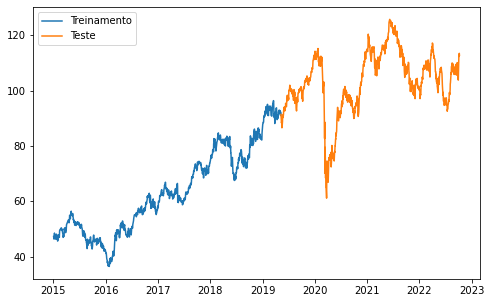

In [52]:
plt.figure(figsize=(8, 5))
plt.plot(treinamento, label="Treinamento")
plt.plot(teste, label="Teste")
plt.legend()

#### Prophet

In [53]:
dataset = pd.read_csv("acoes.csv", usecols=["Date", "BOVA"])

dataset = dataset[["Date", "BOVA"]].rename(columns={"Date": "ds", "BOVA": "y"})
dataset

,ds,y
0,2015-01-02,47.259998
1,2015-01-05,46.320000
2,2015-01-06,46.580002
3,2015-01-07,48.150002
4,2015-01-08,48.509998
...,...,...
1927,2022-10-03,112.400002
1928,2022-10-04,112.349998
1929,2022-10-05,113.320000
1930,2022-10-06,113.470001


Instânciando o modelo Prophet.

In [54]:
modelo = Prophet()

Colocando o modelo para treinar no conjunto de dados.

In [55]:
modelo.fit(dataset) # Treinamento

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
d:\anaconda3\envs\TECII\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


Previsões dos próximos 90 dias.

In [56]:
futuro = modelo.make_future_dataframe(periods=90)
previsoes = modelo.predict(futuro)

previsoes # Coluna yhat

d:\anaconda3\envs\TECII\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)
d:\anaconda3\envs\TECII\lib\site-packages\fbprophet\forecaster.py:891: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  components = components.append(new_comp)


,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,yearly,yearly_lower,yearly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2015-01-02,50.143994,44.149261,57.892285,50.143994,50.143994,1.258890,1.258890,1.258890,0.666565,0.666565,0.666565,0.592326,0.592326,0.592326,0.0,0.0,0.0,51.402885
1,2015-01-05,50.095757,44.631428,59.039480,50.095757,50.095757,1.580953,1.580953,1.580953,0.640904,0.640904,0.640904,0.940050,0.940050,0.940050,0.0,0.0,0.0,51.676711
2,2015-01-06,50.079678,45.349649,58.825015,50.079678,50.079678,1.690499,1.690499,1.690499,0.632866,0.632866,0.632866,1.057634,1.057634,1.057634,0.0,0.0,0.0,51.770177
3,2015-01-07,50.063599,44.382073,59.018743,50.063599,50.063599,1.810960,1.810960,1.810960,0.636976,0.636976,0.636976,1.173985,1.173985,1.173985,0.0,0.0,0.0,51.874559
4,2015-01-08,50.047520,45.180731,58.953922,50.047520,50.047520,1.934085,1.934085,1.934085,0.646131,0.646131,0.646131,1.287954,1.287954,1.287954,0.0,0.0,0.0,51.981605
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2017,2023-01-01,98.968601,90.785107,104.921327,97.797045,100.064068,-1.129378,-1.129378,-1.129378,-1.611720,-1.611720,-1.611720,0.482342,0.482342,0.482342,0.0,0.0,0.0,97.839222
2018,2023-01-02,98.944092,93.016209,107.415273,97.743807,100.061076,1.233229,1.233229,1.233229,0.640904,0.640904,0.640904,0.592326,0.592326,0.592326,0.0,0.0,0.0,100.177322
2019,2023-01-03,98.919584,93.033859,107.300309,97.683394,100.057456,1.338986,1.338986,1.338986,0.632866,0.632866,0.632866,0.706120,0.706120,0.706120,0.0,0.0,0.0,100.258569
2020,2023-01-04,98.895075,92.573926,107.384148,97.619367,100.056936,1.459431,1.459431,1.459431,0.636976,0.636976,0.636976,0.822456,0.822456,0.822456,0.0,0.0,0.0,100.354507


Número de dias previstos.

In [57]:
len(previsoes) - len(dataset)

90

Visualizando as previsões do modelo.

In [58]:
previsoes[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

,ds,yhat,yhat_lower,yhat_upper
0,2015-01-02,51.402885,44.149261,57.892285
1,2015-01-05,51.676711,44.631428,59.039480
2,2015-01-06,51.770177,45.349649,58.825015
3,2015-01-07,51.874559,44.382073,59.018743
4,2015-01-08,51.981605,45.180731,58.953922
...,...,...,...,...
2017,2023-01-01,97.839222,90.785107,104.921327
2018,2023-01-02,100.177322,93.016209,107.415273
2019,2023-01-03,100.258569,93.033859,107.300309
2020,2023-01-04,100.354507,92.573926,107.384148


In [59]:
plot_plotly(modelo, previsoes)

# Binance e TradingView

Download da base de dados usando a Binance.

In [2]:
dados = vbt.BinanceData.download('BTCBRL', start='2022-01-01', interval='15m').get()

d:\anaconda3\envs\TECII\lib\site-packages\dateparser\date_parser.py:35: PytzUsageWarning: The localize method is no longer necessary, as this time zone supports the fold attribute (PEP 495). For more details on migrating to a PEP 495-compliant implementation, see https://pytz-deprecation-shim.readthedocs.io/en/latest/migration.html
  date_obj = stz.localize(date_obj)


0it [00:00, ?it/s]

In [3]:
prices = dados['Close']
prices

Open time
2022-01-01 04:00:00+00:00    263030.0
2022-01-01 04:15:00+00:00    263214.0
2022-01-01 04:30:00+00:00    263489.0
2022-01-01 04:45:00+00:00    263280.0
2022-01-01 05:00:00+00:00    263489.0
                               ...   
2022-10-10 20:45:00+00:00    100269.0
2022-10-10 21:00:00+00:00    100350.0
2022-10-10 21:15:00+00:00    100348.0
2022-10-10 21:30:00+00:00    100230.0
2022-10-10 21:45:00+00:00    100350.0
Freq: 15T, Name: Close, Length: 27144, dtype: float64

In [4]:
media_rapida = vbt.MA.run(prices, 20)
media_lenta = vbt.MA.run(prices, 200)

Se a média rápida cruzar em cima da média lenta, vai gerar um sinal de entrada.

In [5]:
entradas = media_rapida.ma_crossed_above(media_lenta)

Se a média rápida cruzar para baixo da média lenta, vai gerar um sinal de saída.

In [6]:
saidas = media_rapida.ma_crossed_below(media_lenta)

#### Portifólio

In [7]:
pf = vbt.Portfolio.from_signals(prices, entradas, saidas, init_cash=1000)
pf.total_profit()

-344.13834799543804

>**Max Drawdown:** Prejuízo (comprou no momento errado. Pode ter realizado a compra com um preço bom, mas quando fechou, foi em queda). Aceitavel é no máximo 5%.

In [8]:
pf.stats()

Start                         2022-01-01 04:00:00+00:00
End                           2022-10-10 21:45:00+00:00
Period                                282 days 18:00:00
Start Value                                      1000.0
End Value                                    655.861652
Total Return [%]                             -34.413835
Benchmark Return [%]                         -61.848458
Max Gross Exposure [%]                            100.0
Total Fees Paid                                     0.0
Max Drawdown [%]                              38.755877
Max Drawdown Duration                 215 days 09:30:00
Total Trades                                        124
Total Closed Trades                                 124
Total Open Trades                                     0
Open Trade PnL                                      0.0
Win Rate [%]                                  19.354839
Best Trade [%]                                14.074304
Worst Trade [%]                                -

#### TradingView

In [10]:
symbol = 'BTCBRL'

Intervalo de `5 minutos`.

In [11]:
trade5 = TA_Handler(
    symbol=symbol,
    screener='crypto',
    exchange='binance',
    interval=Interval.INTERVAL_5_MINUTES,
)

Intervalo de `15 minutos`.

In [12]:
trade15 = TA_Handler(
    symbol=symbol,
    screener='crypto',
    exchange='binance',
    interval=Interval.INTERVAL_15_MINUTES,
)

Intervalo de `1 hora`.

In [13]:
trade1h = TA_Handler(
    symbol=symbol,
    screener='crypto',
    exchange='binance',
    interval=Interval.INTERVAL_1_HOUR,
)

Intervalo de `1 dia`.

In [14]:
trade1d = TA_Handler(
    symbol=symbol,
    screener='crypto',
    exchange='binance',
    interval=Interval.INTERVAL_1_DAY,
)

Fazendo a análise de cada operação.

In [15]:
operation5 = trade5.get_analysis().summary['RECOMMENDATION']
operation15 = trade15.get_analysis().summary['RECOMMENDATION']
operation1h = trade1h.get_analysis().summary['RECOMMENDATION']
operation1d = trade1d.get_analysis().summary['RECOMMENDATION']

print(
    f"""
    {operation5}
    {operation15}
    {operation1h}
    {operation1d}
    """
)


    SELL
    SELL
    SELL
    STRONG_SELL
    


Fazendo a análise a cada 30 segundos.

In [18]:
while True:
    if operation5 == 'BUY' and operation15 == 'BUY' and operation1h == 'BUY' and operation1d == 'BUY':
        print("Realiza compra.")
    else:
        print(
            f"""
            Sem sinal.
            {trade1d.get_analysis().summary} # Quantidade de indicadores implementados.
            """
        )
    time.sleep(30) # 30 segundos.


        Sem sinal.
        {'RECOMMENDATION': 'STRONG_SELL', 'BUY': 0, 'SELL': 17, 'NEUTRAL': 9} # Quantidade de indicadores implementados.
        


Analizando múltiplos ativos ao mesmo tempo.

In [22]:
multiple_analysis = get_multiple_analysis(
    screener='crypto', 
    interval=Interval.INTERVAL_15_MINUTES,
    symbols=['BINANCE:BTCBRL', 'BINANCE:DOGEBRL', 'BINANCE:ETHBRL'],
)
multiple_analysis

{'BINANCE:BTCBRL': <tradingview_ta.main.Analysis at 0x1d72a6038e0>,
 'BINANCE:DOGEBRL': <tradingview_ta.main.Analysis at 0x1d72a6e4ac0>,
 'BINANCE:ETHBRL': <tradingview_ta.main.Analysis at 0x1d72a6e40d0>}

In [24]:
multiple_analysis['BINANCE:BTCBRL'].summary

{'RECOMMENDATION': 'STRONG_SELL', 'BUY': 1, 'SELL': 16, 'NEUTRAL': 9}

In [26]:
multiple_analysis['BINANCE:DOGEBRL'].summary

{'RECOMMENDATION': 'STRONG_SELL', 'BUY': 0, 'SELL': 17, 'NEUTRAL': 9}

In [27]:
multiple_analysis['BINANCE:ETHBRL'].summary

{'RECOMMENDATION': 'STRONG_SELL', 'BUY': 0, 'SELL': 16, 'NEUTRAL': 10}

# Árvore de decisões

In [74]:
df = yf.download('CVCB3.SA', start='2015-01-01')

[*********************100%***********************]  1 of 1 completed


Função para limpar o dataset (remove valores vazios/NaN e define o tipo).

In [75]:
def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), 'df precisa ser DataFrame'
    df.dropna(inplace=True)
    indices = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices].astype(np.float64)

In [76]:
clean_dataset(df)

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2015-01-02,15.40,15.42,15.07,15.20,13.712903,95400.0
2015-01-05,15.37,15.37,14.88,15.00,13.532470,132600.0
2015-01-06,14.99,15.44,14.70,14.80,13.352037,133300.0
2015-01-07,14.89,14.95,14.58,14.67,13.234755,139600.0
2015-01-08,14.76,14.80,14.15,14.15,12.765632,198000.0
...,...,...,...,...,...,...
2022-10-03,6.55,6.79,6.50,6.75,6.750000,16482300.0
2022-10-04,6.96,7.15,6.81,6.88,6.880000,15530000.0
2022-10-05,6.88,7.03,6.70,7.00,7.000000,13048600.0


Média móvel exponencial de 10.

In [77]:
df['EMA10'] = ta.EMA(df['Close'].values, timeperiod=10)

As primeiras 10 linhas são `NaN` por conta da média móvel.

In [78]:
df['EMA10']

Date
2015-01-02         NaN
2015-01-05         NaN
2015-01-06         NaN
2015-01-07         NaN
2015-01-08         NaN
                ...   
2022-10-03    6.669945
2022-10-04    6.708137
2022-10-05    6.761203
2022-10-06    6.830075
2022-10-07    6.857334
Name: EMA10, Length: 1932, dtype: float64

Média móvel exponencial de 30.

In [79]:
df['EMA30'] = ta.EMA(df['Close'].values, timeperiod=30)

As primeiras 30 linhas são `NaN` por conta da média móvel.

In [80]:
df['EMA30']

Date
2015-01-02         NaN
2015-01-05         NaN
2015-01-06         NaN
2015-01-07         NaN
2015-01-08         NaN
                ...   
2022-10-03    7.102339
2022-10-04    7.087995
2022-10-05    7.082318
2022-10-06    7.086039
2022-10-07    7.079198
Name: EMA30, Length: 1932, dtype: float64

Calculando ATR, ADX, RSI e MACD.

In [81]:
df['ATR'] = ta.ATR(df['High'].values, df['Low'].values, df['Close'].values, timeperiod=14)
df['ADX'] = ta.ADX(df['High'].values, df['Low'].values, df['Close'].values, timeperiod=14)
df['RSI'] = ta.RSI(df['Close'].values, timeperiod=14)

macd, macdsignal, macdhist = ta.MACD(df['Close'].values, fastperiod=12, slowperiod=26, signalperiod=9)

df['MACD'] = macd
df['MACDsignal'] = macdsignal

Definindo valores de Compra (`1`) e Venda (`-1`).

In [82]:
df['ClgtEMA10'] = np.where(df['Close'] > df['EMA10'], 1, -1)
df['EMA10gtEMA30'] = np.where(df['EMA10'] > df['EMA30'], 1, -1)
df['MACDSignalMACD'] = np.where(df['MACDsignal'] > df['MACD'], 1, -1)

In [83]:
predictors_list = ['ATR', 'ADX', 'RSI', 'ClgtEMA10', 'EMA10gtEMA30', 'MACDSignalMACD']

In [84]:
clean_dataset(df)

,Open,High,Low,Close,Adj Close,Volume,EMA10,EMA30,ATR,ADX,RSI,MACD,MACDsignal,ClgtEMA10,EMA10gtEMA30,MACDSignalMACD
Date,,,,,,,,,,,,,,,,
2015-02-20,14.68,14.85,14.50,14.60,13.171605,70700.0,14.444525,14.187958,0.537158,32.955478,52.783629,0.100310,-0.070719,1.0,1.0,-1.0
2015-02-23,14.58,14.71,14.27,14.30,12.900955,113400.0,14.418248,14.195187,0.530218,30.855751,48.290942,0.087545,-0.039066,-1.0,1.0,-1.0
2015-02-24,14.21,14.48,14.13,14.35,12.946062,279400.0,14.405839,14.205175,0.517345,28.744612,49.069021,0.080534,-0.015146,-1.0,1.0,-1.0
2015-02-25,14.29,14.78,14.22,14.46,13.045300,98200.0,14.415686,14.221615,0.520392,27.305510,50.822217,0.082899,0.004463,1.0,1.0,-1.0
2015-02-26,14.39,14.53,13.90,14.34,12.937041,483200.0,14.401925,14.229253,0.528221,25.523748,48.846800,0.074234,0.018417,-1.0,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-10-03,6.55,6.79,6.50,6.75,6.750000,16482300.0,6.669945,7.102339,0.437181,15.156966,45.191798,-0.307923,-0.225772,1.0,-1.0,1.0
2022-10-04,6.96,7.15,6.81,6.88,6.880000,15530000.0,6.708137,7.087995,0.434525,14.094644,47.313265,-0.273784,-0.235375,1.0,-1.0,1.0
2022-10-05,6.88,7.03,6.70,7.00,7.000000,13048600.0,6.761203,7.082318,0.427059,13.335089,49.265431,-0.234345,-0.235169,1.0,-1.0,-1.0


Amostras (samples).

In [85]:
X = df[predictors_list]
X.tail()

,ATR,ADX,RSI,ClgtEMA10,EMA10gtEMA30,MACDSignalMACD
Date,,,,,,
2022-10-03,0.437181,15.156966,45.191798,1,-1,1
2022-10-04,0.434525,14.094644,47.313265,1,-1,1
2022-10-05,0.427059,13.335089,49.265431,1,-1,-1
2022-10-06,0.411555,12.543814,51.522212,1,-1,-1
2022-10-07,0.397872,11.675683,48.847923,1,-1,-1


Calcula o retorno entre os dias (D, D+1).

In [86]:
df['Return'] = df['Close'].pct_change(1).shift(-1)

Verifica se é positivo ou não. Se for positivo, realiza compra (`1`), senão, não realiza a compra (`0`).

In [87]:
df['target'] = np.where(df.Return > 0, 1, 0) 

Rótulos (labels).

In [88]:
y = df.target
y.tail()

Date
2022-10-03    1
2022-10-04    1
2022-10-05    1
2022-10-06    0
2022-10-07    0
Name: target, dtype: int32

Dividindo o dataset em um conjunto de treino e um conjunto de teste.

In [90]:
X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.3,
    random_state=10,
    stratify=y,
)

Criando a árvore de decisão.

In [93]:
clg = DecisionTreeClassifier(
    criterion='gini',
    max_depth=3,
    min_samples_leaf=6,
)
clg = clg.fit(X_train, y_train)

Visualizando a árvore de decisão.

[Text(482.8846153846154, 713.475, 'ADX <= 16.133\ngini = 0.498\nsamples = 1329\nvalue = [701, 628]\nclass = Compra'),
 Text(257.53846153846155, 509.625, 'ATR <= 1.734\ngini = 0.477\nsamples = 288\nvalue = [175, 113]\nclass = Compra'),
 Text(128.76923076923077, 305.775, 'RSI <= 33.866\ngini = 0.491\nsamples = 220\nvalue = [125, 95]\nclass = Compra'),
 Text(64.38461538461539, 101.92499999999995, 'gini = 0.278\nsamples = 6\nvalue = [1, 5]\nclass = Venda'),
 Text(193.15384615384616, 101.92499999999995, 'gini = 0.487\nsamples = 214\nvalue = [124, 90]\nclass = Compra'),
 Text(386.3076923076923, 305.775, 'ATR <= 1.831\ngini = 0.389\nsamples = 68\nvalue = [50, 18]\nclass = Compra'),
 Text(321.9230769230769, 101.92499999999995, 'gini = 0.153\nsamples = 24\nvalue = [22, 2]\nclass = Compra'),
 Text(450.69230769230774, 101.92499999999995, 'gini = 0.463\nsamples = 44\nvalue = [28, 16]\nclass = Compra'),
 Text(708.2307692307693, 509.625, 'RSI <= 78.726\ngini = 0.5\nsamples = 1041\nvalue = [526, 515]

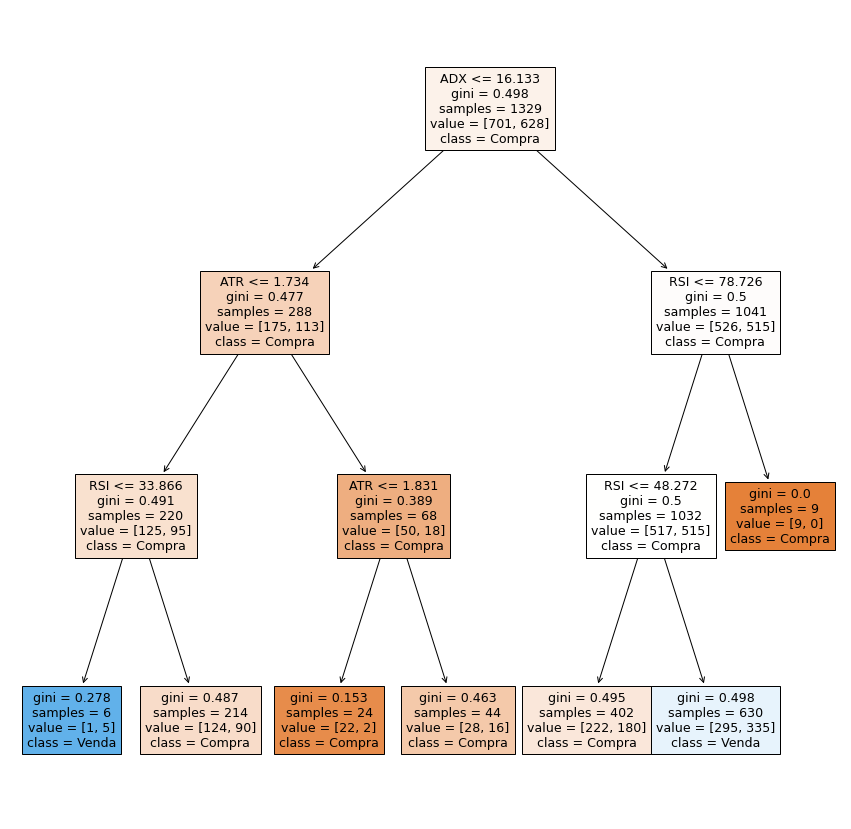

In [94]:
figura, eixos = plt.subplots(nrows=1, ncols=1, figsize=(15, 15))
atributos = predictors_list
classes = ['Compra', 'Venda']
tree.plot_tree(
    clg,
    feature_names=atributos,
    class_names=classes,
    filled=True
)

Valores da última linha do conjunto de treino.

In [98]:
X.tail(1)

,ATR,ADX,RSI,ClgtEMA10,EMA10gtEMA30,MACDSignalMACD
Date,,,,,,
2022-10-07,0.397872,11.675683,48.847923,1,-1,-1


In [96]:
prev = clg.predict([[0.397872,	11.675683,	48.847923,	1,	-1,	-1]])

if prev[0] == 0:
    print('Compra')
else:
    print('Venda')

Compra


# Análise de correlação

Download da base de dados.

In [100]:
acoes = [
    "GOLL4.SA",
    "CVCB3.SA",
    "WEGE3.SA",
    "MGLU3.SA",
    "TOTS3.SA",
    "PETR4.SA",
    "BOVA11.SA",
]

acoes_df = pd.DataFrame()

# Download dos dados dos ativos.
for acao in acoes:
    acoes_df[acao] = yf.download(acao, start="2019-01-01")["Close"]

acoes_df = acoes_df.rename(
    columns={
        "GOLL4.SA": "GOL",
        "CVCB3.SA": "CVC",
        "WEGE3.SA": "WEGE",
        "MGLU3.SA": "MGLU",
        "TOTS3.SA": "TOTS",
        "PETR4.SA": "PETR",
        "BOVA11.SA": "BOVA",
    }
)

# Download dos dados do Dolar.
dolar = yf.download("USDBRL=X", start="2019-01-01")
dolar = pd.DataFrame(dolar.Close).rename(columns={"Close": "DOLAR"})

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


In [101]:
dfs = [acoes_df, dolar]

dfFinal = reduce(lambda left, right : pd.merge(
    left,
    right,
    on='Date',
    how='inner',
), dfs)

dfFinal.dropna(inplace=True)
dfFinal

,GOL,CVC,WEGE,MGLU,TOTS,PETR,BOVA,DOLAR
Date,,,,,,,,
2019-01-02,25.450001,61.099998,8.990000,5.812187,9.531889,24.059999,87.900002,3.8799
2019-01-03,25.629999,60.709999,9.195000,5.750000,9.751472,24.650000,88.000000,3.7863
2019-01-04,25.000000,59.950001,9.300000,5.575000,10.020960,24.719999,88.500000,3.7551
2019-01-07,23.900000,60.700001,9.155000,5.661562,9.804704,25.110001,88.480003,3.6612
2019-01-08,23.590000,58.709999,9.080000,5.615937,9.405462,24.959999,88.830002,3.7341
...,...,...,...,...,...,...,...,...
2022-10-03,10.050000,6.750000,33.580002,4.910000,30.950001,32.180000,112.400002,5.4143
2022-10-04,10.190000,6.880000,33.240002,5.090000,31.129999,31.370001,112.349998,5.1635
2022-10-05,10.480000,7.000000,33.669998,5.120000,31.309999,32.549999,113.320000,5.1758


<AxesSubplot:>

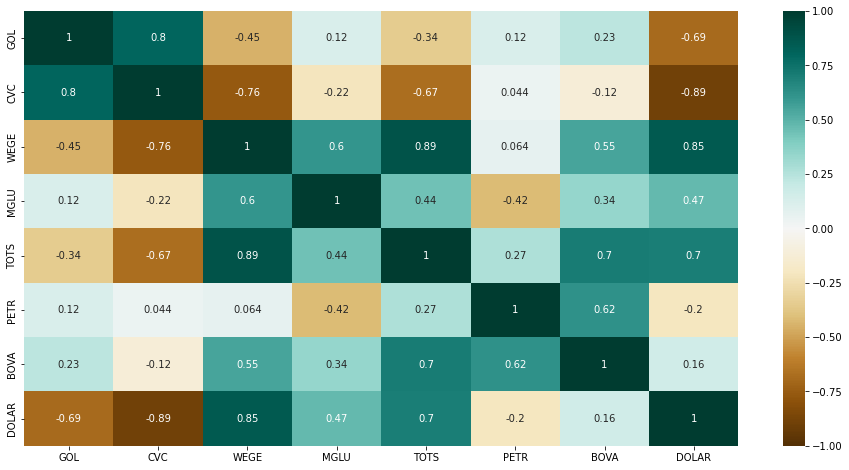

In [102]:
plt.figure(figsize=(16, 8))
sns.heatmap(
    dfFinal.corr(),
    vmin=-1,
    vmax=1,
    annot=True,
    cmap='BrBG',
)